In [1]:
# General:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns

# For plotting and visualization:
from IPython.display import display
from textblob import TextBlob
from wordcloud import WordCloud
from credentials import *    # This will allow us to use the keys as variables
from textblob import TextBlob
from wordcloud import STOPWORDS
from collections import Counter

%matplotlib inline

In [2]:
import os
import nltk
#nltk.download('stopwords')

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.feature_selection import RFE

#import xgboost as xgb
#import gensim

/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Access:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True)


def get_tweet_to_csv(filename, hashtaglist):
    csvFile = open(filename, 'a')
    #Use csv Writer
    csvWriter = csv.writer(csvFile)
    
    for tags in hashtaglist:
        for tweet in tweepy.Cursor(api.search, q=tags, count=1000, lang='en').items():
            csvWriter.writerow([tweet.id, tweet.created_at, tweet.text, tweet.source, tweet.favorite_count, tweet.retweet_count])

def count_occurences(character, word_array):
            counter = 0
            for j, word in enumerate(word_array):
                for char in word:
                    if char == character:
                        counter += 1
            return counter

def count_by_lambda(expression, word_array):
            return len(list(filter(expression, word_array)))


In [4]:
from textblob import TextBlob
import re

def clean_tweet(text):
    '''
    Utility function to clean the text in a tweet by removing links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

def analize_sentiment(text):
    '''
    Utility function to classify the polarity of a tweet using textblob.
    '''
    analysis = TextBlob(clean_tweet(text))
    return analysis.sentiment.polarity


In [5]:
#scrape Yelp public review data for citibike # one time use only.
import requests
import re

rows = []
columns = ['yelp_review']
review_pattern = re.compile(r'"description":(.*?)", "author"')

for n in np.arange(0,16):
    x=n*20
    url = 'https://www.yelp.com/biz/citi-bike-new-york-6?start=%s'% x
    html = requests.get(url).text
    for this_review in re.findall(review_pattern, html):
        row = [this_review]
        rows.append(row)
        df = pd.DataFrame(rows, columns=columns)
    
# Use pandas to write the comma-separated output file
df.to_csv("yelp_review.csv", mode='a',  sep=',', quoting=0)   

In [6]:
#get twitter data
hashtaglist = ['#CitiBike','#citibike', '#bikenyc']

get_tweet_to_csv('citibike.csv',hashtaglist)

In [7]:
col_Names = ["id","created", "tweet","source","fav_count","retweet"]
data_tweet = pd.read_csv('citibike.csv', names=col_Names)

data_yelp1 = pd.read_csv('yelp_review.csv')
data_yelp = data_yelp1.drop(['Unnamed: 0'], axis=1)


# We display the first 10 elements of the dataframe:
display(data_tweet.info())
display(data_yelp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5084 entries, 0 to 5083
Data columns (total 6 columns):
id           5084 non-null int64
created      5084 non-null object
tweet        5084 non-null object
source       5084 non-null object
fav_count    5084 non-null int64
retweet      5084 non-null int64
dtypes: int64(3), object(3)
memory usage: 238.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Data columns (total 1 columns):
yelp_review    1925 non-null object
dtypes: object(1)
memory usage: 15.1+ KB


None

In [8]:
data_tweet['len'] = data_tweet['tweet'].apply(len)
data_tweet['tweet_date'] = pd.to_datetime(data_tweet['created']).dt.date
    
data_tweet['uppercase_no'] = list(map(lambda txt: count_by_lambda(lambda word: word == word.upper(), txt),data_tweet["tweet"]))
data_tweet['hashtag_no'] = list(map(lambda txt: count_occurences("#", txt),data_tweet["tweet"]))
data_tweet['exclamation_no'] = list(map(lambda txt: count_occurences("!", txt),data_tweet["tweet"]))
data_tweet['question_no'] = list(map(lambda txt: count_occurences("?", txt),data_tweet["tweet"]))
data_tweet['mention_no'] = list(map(lambda txt: count_occurences("@", txt),data_tweet["tweet"]))

display(data_tweet.head(10))


data_yelp['len'] = data_yelp['yelp_review'].apply(len)
data_yelp['uppercase_no'] = list(map(lambda txt: count_by_lambda(lambda word: word == word.upper(), txt),data_yelp["yelp_review"]))
data_yelp['hashtag_no'] = list(map(lambda txt: count_occurences("#", txt),data_yelp["yelp_review"]))
data_yelp['exclamation_no'] = list(map(lambda txt: count_occurences("!", txt),data_yelp["yelp_review"]))
data_yelp['question_no'] = list(map(lambda txt: count_occurences("?", txt),data_yelp["yelp_review"]))
data_yelp['mention_no'] = list(map(lambda txt: count_occurences("@", txt),data_yelp["yelp_review"]))

display(data_yelp.head(10))

,id,created,tweet,source,fav_count,retweet,len,tweet_date,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no
0,965631397951139841,2018-02-19 16:57:20,Just activated my #citibike key!,Twitter for iPhone,1,0,32,2018-02-19,7,1,1,0,0
1,965585950318497792,2018-02-19 13:56:44,RT @CitiBikeNYC: Pro Tip: Signal your turns an...,Twitter for iPhone,0,2,140,2018-02-19,46,2,0,0,1
2,965575650131181568,2018-02-19 13:15:49,RT @CitiBikeNYC: Pro Tip: Signal your turns an...,Twitter Web Client,0,2,140,2018-02-19,46,2,0,0,1
3,965575236593897477,2018-02-19 13:14:10,Pro Tip: Signal your turns and lane changes so...,Sprout Social,0,2,124,2018-02-19,34,2,0,0,0
4,965261142414290946,2018-02-18 16:26:04,New Yorkers- the only #childbikeseat that work...,Instagram,0,0,119,2018-02-18,35,2,0,0,0
5,965022780898054144,2018-02-18 00:38:54,RT @CitiBikeNYC: Pro Tip: Wool socks will keep...,Twitter for Android,0,2,140,2018-02-18,49,2,0,0,1
6,964863526954258432,2018-02-17 14:06:05,RT @CitiBikeNYC: Pro Tip: Wool socks will keep...,Twitter Web Client,0,2,140,2018-02-17,49,2,0,0,1
7,964863020840210433,2018-02-17 14:04:05,"Pro Tip: Wool socks will keep your feet warm, ...",Sprout Social,5,2,129,2018-02-17,41,2,0,0,0
8,964506722906857472,2018-02-16 14:28:17,Hard keeping this one off a bike... best way t...,Instagram,0,0,116,2018-02-16,39,3,1,0,0
9,964158494365626369,2018-02-15 15:24:32,"With only 100 calories, this will be a breeze ...",IFTTT,1,0,131,2018-02-15,43,3,0,0,0


,yelp_review,len,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no
0,"""While Citi Bike can be a convenient way to g...",859,223,0,1,0,0
1,"""Had good experiences over the summer but not...",734,178,0,1,0,0
2,"""Great way to get around Brooklyn (\u0026 NYC...",420,104,0,0,0,0
3,"""I wanted to a rent a bike for sightseeing in...",439,113,0,1,0,0
4,"""Works like any other city bike rental BUT th...",579,159,0,0,0,0
5,"""A good idea in theory, with terrible executi...",1458,379,0,1,0,0
6,"""Deadly combo of raising rates whilst service...",384,90,0,2,0,0
7,"""This is a review of my annual membership. I ...",1169,276,0,1,0,0
8,"""UPDATE! \nWoke up to find I am being charged...",1028,295,0,12,0,0
9,"""I will never ever rent a bike from this comp...",174,43,0,0,0,0


In [9]:
# Extract the mean of tweet lenghts:
mean = np.mean(data_tweet['len'])
print("The length's average in tweets: {}".format(mean))

# Extract the top tweets with most FAVs and more RTs:

fav_max = np.max(data_tweet['fav_count'])
rt_max  = np.max(data_tweet['retweet'])

fav = data_tweet[data_tweet.fav_count == fav_max].index[0]
rt  = data_tweet[data_tweet.retweet == rt_max].index[0]

# Max FAVs:
print("The tweet with most no of likes is: \n{}".format(data_tweet['tweet'][fav]))
print("Number of likes: {}".format(fav_max))
print("{} characters.\n".format(data_tweet['len'][fav]))

# Max RTs:
print("The tweet with most no of retweets is: \n{}".format(data_tweet['tweet'][rt]))
print("Number of retweets: {}".format(rt_max))
print("{} characters.\n".format(data_tweet['len'][rt]))

The length's average in tweets: 130.46262785208498
The tweet with most no of likes is: 
If I can ride my bike on #QueensBlvd safely, at night, in the rain, in February, then anything is possible.… https://t.co/crTqIGy7EX
Number of likes: 85
132 characters.

The tweet with most no of retweets is: 
@NYPDTransport parked in bike lane, actually eating a sandwich, forcing rush hour bikers out of city hall bike lane… https://t.co/NupDjj15Ia
Number of retweets: 43
140 characters.



In [10]:
# Create time series for data:

tlen = pd.Series(data=data_tweet['len'].values, index=data_tweet['created'])
tfav = pd.Series(data=data_tweet['fav_count'].values, index=data_tweet['created'])
tret = pd.Series(data=data_tweet['retweet'].values, index=data_tweet['created'])

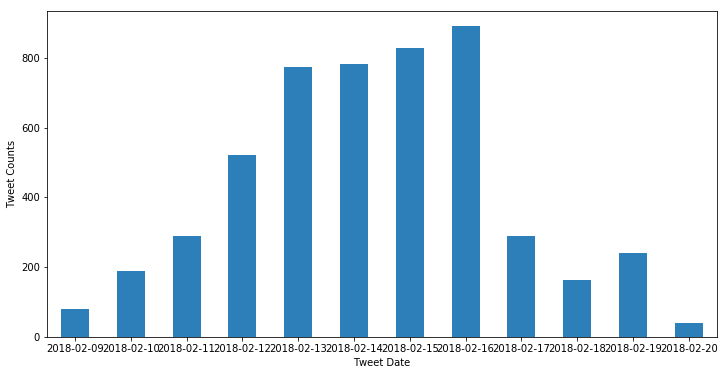

In [11]:
# No of Trips by Day:

df = data_tweet.groupby(['tweet_date']).agg({'id':'count'})
df.plot(kind = 'bar', figsize=(12, 6), color='#2c7fb8', linewidth=.03, label="No of Tweets", legend=False)
_ = plt.xticks(rotation=0)
_ = plt.ylabel('Tweet Counts')
_ = plt.xlabel('Tweet Date')

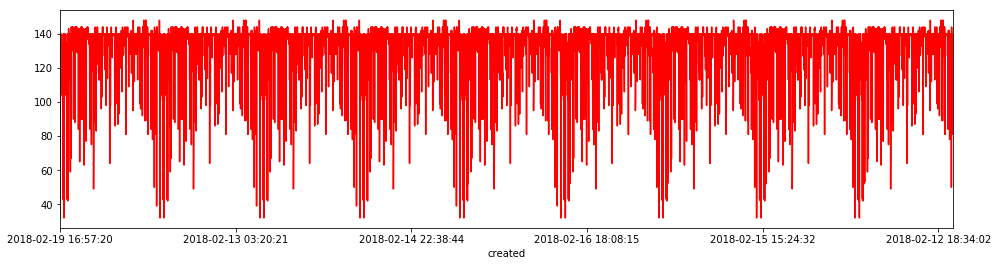

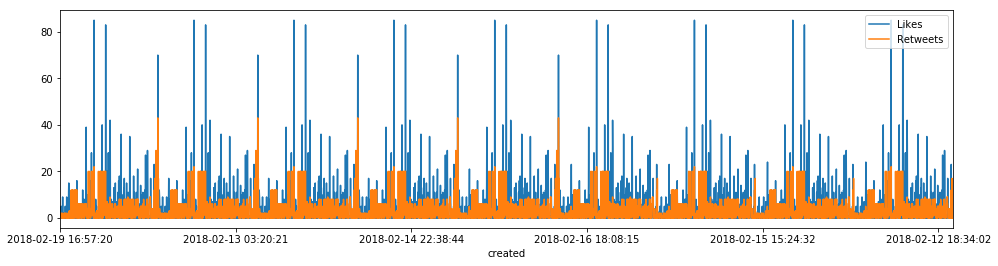

In [12]:
# Lenghts along time:
tlen.plot(figsize=(16,4), color='r');
plt.show()

# Likes vs retweets visualization:
tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True);
plt.show()


In [13]:
# We obtain all possible sources:
sources = []
for source in data_tweet['source']:
    if source not in sources:
        sources.append(source)

# We print sources list:
print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

Creation of content sources:
* Twitter for iPhone
* Twitter Web Client
* Sprout Social
* Instagram
* Twitter for Android
* IFTTT
* Twitter Lite
* Hootsuite
* Reported_NYC
* Zapier.com
* Tweetbot for iΟS
* Buffer
* TweetDeck
* Twitter for iPad
* CyclingBot
* Talon Android
* Twitter for Mac
* Email Comps Verified
* AccBiking1
* Tweetbot for Mac
* ShouldIBikeToday
* Fenix 2 Preview
* Elysian Pedestrian Path
* tofubot


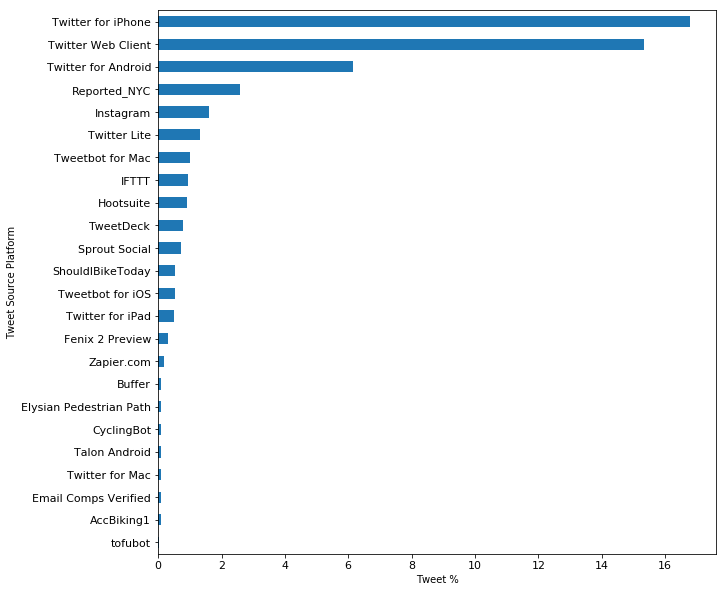

In [14]:
# Create a numpy vector mapped to labels:
percent = np.zeros(len(sources))

for source in data_tweet['source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100

data = pd.Series(percent, index=sources, name='sources')
data.sort_values(ascending=True, inplace=True)

data.plot.barh(fontsize=11, figsize=(10, 10));
_ = plt.xlabel('Tweet %')
_ = plt.ylabel('Tweet Source Platform')

In [15]:
# We create a column with the result of the analysis:

#df_sub['free_trip'] = np.where(df_sub['tripduration'] <= 2700, 1, 0)
data_tweet['score'] = np.around(np.array([ analize_sentiment(tweet) for tweet in data_tweet['tweet'] ]),3)
data_tweet['SA'] = np.where(data_tweet['score'] > 0, 1, (np.where(data_tweet['score'] < 0, -1, 0)))

# We display the updated dataframe with the new column:
display(data_tweet.head(10))


,id,created,tweet,source,fav_count,retweet,len,tweet_date,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,score,SA
0,965631397951139841,2018-02-19 16:57:20,Just activated my #citibike key!,Twitter for iPhone,1,0,32,2018-02-19,7,1,1,0,0,0.000,0
1,965585950318497792,2018-02-19 13:56:44,RT @CitiBikeNYC: Pro Tip: Signal your turns an...,Twitter for iPhone,0,2,140,2018-02-19,46,2,0,0,1,0.000,0
2,965575650131181568,2018-02-19 13:15:49,RT @CitiBikeNYC: Pro Tip: Signal your turns an...,Twitter Web Client,0,2,140,2018-02-19,46,2,0,0,1,0.000,0
3,965575236593897477,2018-02-19 13:14:10,Pro Tip: Signal your turns and lane changes so...,Sprout Social,0,2,124,2018-02-19,34,2,0,0,0,0.000,0
4,965261142414290946,2018-02-18 16:26:04,New Yorkers- the only #childbikeseat that work...,Instagram,0,0,119,2018-02-18,35,2,0,0,0,0.068,1
5,965022780898054144,2018-02-18 00:38:54,RT @CitiBikeNYC: Pro Tip: Wool socks will keep...,Twitter for Android,0,2,140,2018-02-18,49,2,0,0,1,0.444,1
6,964863526954258432,2018-02-17 14:06:05,RT @CitiBikeNYC: Pro Tip: Wool socks will keep...,Twitter Web Client,0,2,140,2018-02-17,49,2,0,0,1,0.444,1
7,964863020840210433,2018-02-17 14:04:05,"Pro Tip: Wool socks will keep your feet warm, ...",Sprout Social,5,2,129,2018-02-17,41,2,0,0,0,0.444,1
8,964506722906857472,2018-02-16 14:28:17,Hard keeping this one off a bike... best way t...,Instagram,0,0,116,2018-02-16,39,3,1,0,0,0.354,1
9,964158494365626369,2018-02-15 15:24:32,"With only 100 calories, this will be a breeze ...",IFTTT,1,0,131,2018-02-15,43,3,0,0,0,0.000,0


In [16]:

data_yelp['score'] = np.around(np.array([ analize_sentiment(review) for review in data_yelp['yelp_review'] ]),3)
data_yelp['SA'] = np.where(data_yelp['score'] > 0, 1, (np.where(data_yelp['score'] < 0, -1, 0)))
display(data_yelp.head(10))

,yelp_review,len,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,score,SA
0,"""While Citi Bike can be a convenient way to g...",859,223,0,1,0,0,0.172,1
1,"""Had good experiences over the summer but not...",734,178,0,1,0,0,0.064,1
2,"""Great way to get around Brooklyn (\u0026 NYC...",420,104,0,0,0,0,0.126,1
3,"""I wanted to a rent a bike for sightseeing in...",439,113,0,1,0,0,0.076,1
4,"""Works like any other city bike rental BUT th...",579,159,0,0,0,0,0.002,1
5,"""A good idea in theory, with terrible executi...",1458,379,0,1,0,0,-0.086,-1
6,"""Deadly combo of raising rates whilst service...",384,90,0,2,0,0,0.225,1
7,"""This is a review of my annual membership. I ...",1169,276,0,1,0,0,0.163,1
8,"""UPDATE! \nWoke up to find I am being charged...",1028,295,0,12,0,0,0.231,1
9,"""I will never ever rent a bike from this comp...",174,43,0,0,0,0,0.133,1


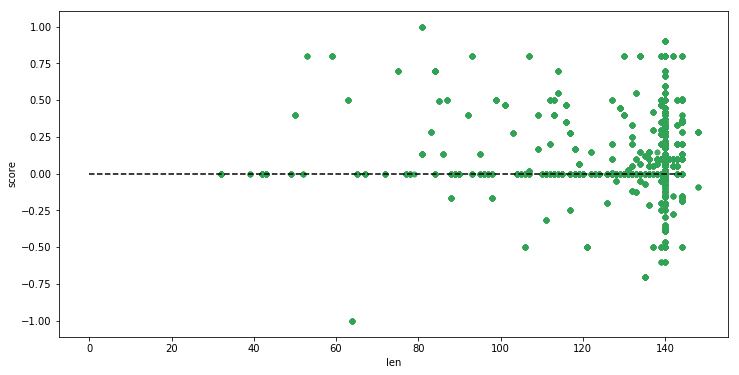

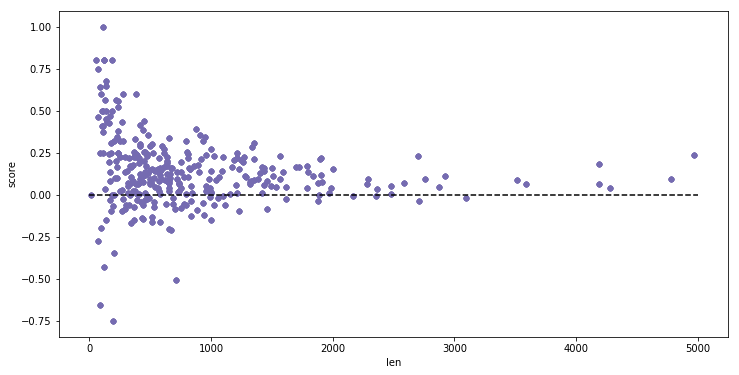

In [17]:
data_tweet.plot.scatter(x='len', y='score', figsize=(12, 6), color='#31a354', alpha=.7, linewidth=.3, s=30);
plt.plot([0, 144], [0, 0], 'k--', color="Black")
plt.show()


data_yelp.plot.scatter(x='len', y='score', figsize=(12, 6), color='#756bb1', alpha=.7, linewidth=.3, s=30);
plt.plot([0, 5000], [0, 0], 'k--', color="Black")
plt.show()

In [18]:
# Construct lists with classified tweets:
pos_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] < 0]

In [19]:
# Print percentages:

pos_tweet_count = len(pos_tweets)*100/len(data_tweet['tweet'])
neu_tweet_count = len(neu_tweets)*100/len(data_tweet['tweet'])
neg_tweet_count = len(neg_tweets)*100/len(data_tweet['tweet'])
                                    
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(data_tweet['tweet'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(data_tweet['tweet'])))
print("Percentage for negative tweets: {}%".format(len(neg_tweets)*100/len(data_tweet['tweet'])))


Percentage of positive tweets: 45.830055074744294%
Percentage of neutral tweets: 40.67663257277734%
Percentage for negative tweets: 13.493312352478364%


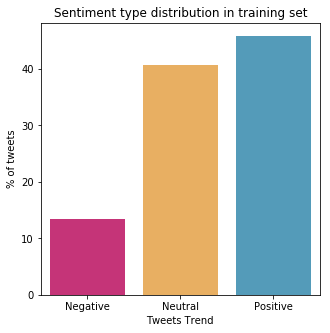

In [20]:
colors = ['#dd1c77','#feb24c','#43a2ca']
x_bar=["Negative","Neutral","Positive"]
y_bar=[neg_tweet_count, neu_tweet_count, pos_tweet_count]
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax = sns.barplot(x=x_bar, y=y_bar,palette=colors);
ax.set(ylabel='% of tweets', xlabel='Tweets Trend')
title = 'Sentiment type distribution in training set'
plt.title(title,fontsize = 12)
plt.show()

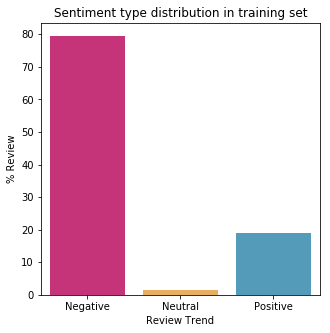

In [21]:
pos_review = [ review for index, review in enumerate(data_yelp['yelp_review']) if data_yelp['SA'][index] > 0]
neu_review = [ review for index, review in enumerate(data_yelp['yelp_review']) if data_yelp['SA'][index] == 0]
neg_review = [ review for index, review in enumerate(data_yelp['yelp_review']) if data_yelp['SA'][index] < 0]


pos_review_count = len(pos_review)*100/len(data_yelp['yelp_review'])
neu_review_count = len(neu_review)*100/len(data_yelp['yelp_review'])
neg_review_count = len(neg_review)*100/len(data_yelp['yelp_review'])

colors = ['#dd1c77','#feb24c','#43a2ca']
x_bar=["Negative","Neutral","Positive"]
y_bar=[pos_review_count, neu_review_count, neg_review_count]
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax = sns.barplot(x=x_bar, y=y_bar,palette=colors);
ax.set(ylabel='% Review', xlabel='Review Trend')
title = 'Sentiment type distribution in training set'
plt.title(title,fontsize = 12)
plt.show()

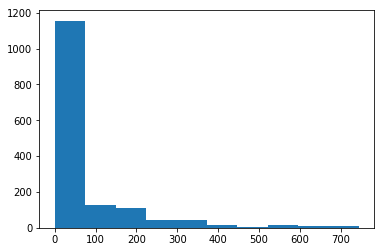

In [22]:
# Removing stopwords and punctuation for proper bigram creation

all_words3 = ', '.join(data_tweet.tweet)

# Combine all tweets and Split the script into lines: lines

for tweet in [all_words3] :
    
    lines = tweet.split('\n')

    # Replace all script lines for speaker
    pattern = "[A-Z]{2,}(\s)?(#\d)?([A-Z]{2,})?:"
    lines = [re.sub(pattern, '', l) for l in lines]

    # Tokenize each line: tokenized_lines
    tokenized_tweets = [regexp_tokenize(s, '\w+') for s in lines]

    # Make a frequency list of lengths: line_num_words
    line_num_words = [len(t_line) for t_line in tokenized_tweets]

    # Plot a histogram of the line lengths
    plt.hist(line_num_words)

# Show the plot
plt.show()

Single Cloud:


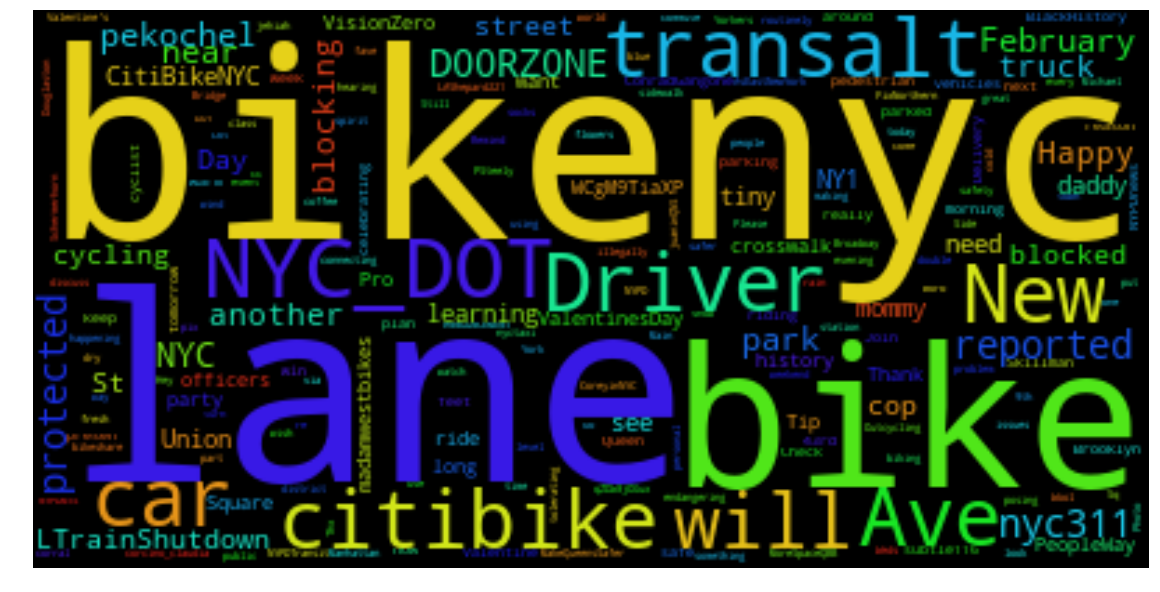

Bigrams:


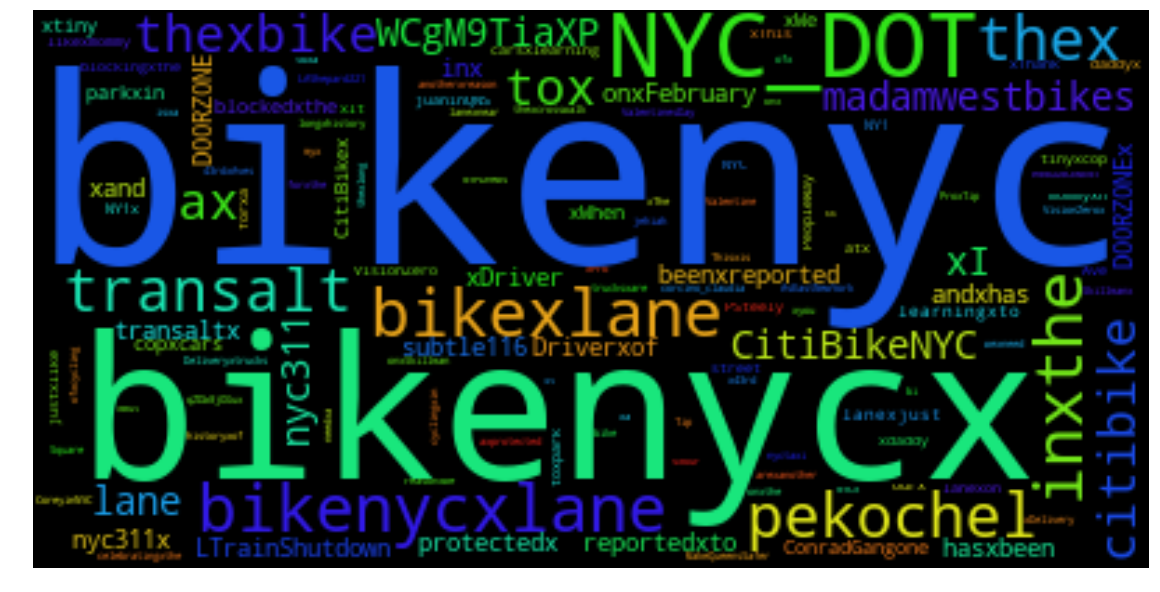

In [23]:
def bigram(text):
    count = 0
    text_bigram = ''
    for letter in text:
        if letter != ' ':
            text_bigram += letter
        else:
            count += 1
            if count % 2 == 0:
                text_bigram += 'x'
            else:
                text_bigram += letter
    return text_bigram

stopwords1 = ['https', 'RT', 'http', '.co', 'amp']
for stopword in stopwords1:
    all_words3 = all_words3.replace(stopword,'')

words_bigram = bigram(all_words3)


# Single Cloud
wordcloud = WordCloud().generate(all_words3)
print('Single Cloud:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

# Bigram Cloud
wordcloud_bigrams = WordCloud().generate(words_bigram)
print('Bigrams:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis("off")
plt.show();

In [24]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('citibike_data.xls', engine='xlsxwriter')
# Convert the dataframe to an XlsxWriter Excel object.
data_tweet.to_excel(writer, sheet_name='Sheet1')
# Close the Pandas Excel writer and output the Excel file.
writer.save()


# Now lets cleanup the twitter data

### Data Cleaning and Text Preprocessing

<div class="span25 alert alert-warning">
Here, header=0 indicates the first line of the tsv file contains the column names, delimiter="\t" means the file uses tap as delimiter, and quoting=3 tells Python to ignore double quotes.

Take a look at the training data.
</div>

<div class="span25 alert alert-info">
Removing HTML Markup with The BeautifulSoup Package.

Even though the review text is not in HTML, let's use the package BeautifulSoup.
<br> </br>
Use re package to remove digits and punctuations. To build a simplified Bag-of-words model, we remove both digits and punctuations.
<br> </br>
Convert words into lower case and tonkenize, i.e. split the text into individual words.

<br></br>

The reviews are now list of word strings.

</div>

In [25]:
data_tweet['tweet_bs'] = data_tweet['tweet'].apply(lambda x: BeautifulSoup(x, 'html.parser'))
data_tweet.tweet_bs[0].get_text()

data_tweet['tweet_letters_only'] = data_tweet['tweet_bs'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x.get_text()))
data_tweet['tweet_letters_only'][0]

data_tweet['tweet_words'] = data_tweet['tweet_letters_only'].apply(lambda x: x.lower().split())
data_tweet['tweet_words'][0]

['just', 'activated', 'my', 'citibike', 'key']

In [26]:
train = pd.read_excel('citibike_data.xls', header=0, delimiter="\t", quoting=3)
print('Dimension of Labeled Training Data: {}.'.format(train.shape))
print('There are {0} samples and {1} variables in the training data.'.format(train.shape[0], train.shape[1]))

display(train.head())
print(train.tweet[0])

Dimension of Labeled Training Data: (5084, 15).
There are 5084 samples and 15 variables in the training data.


,id,created,tweet,source,fav_count,retweet,len,tweet_date,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,score,SA
0,965631397951139840,2018-02-19 16:57:20,Just activated my #citibike key!,Twitter for iPhone,1,0,32,2018-02-19,7,1,1,0,0,0.000,0
1,965585950318497792,2018-02-19 13:56:44,RT @CitiBikeNYC: Pro Tip: Signal your turns an...,Twitter for iPhone,0,2,140,2018-02-19,46,2,0,0,1,0.000,0
2,965575650131181568,2018-02-19 13:15:49,RT @CitiBikeNYC: Pro Tip: Signal your turns an...,Twitter Web Client,0,2,140,2018-02-19,46,2,0,0,1,0.000,0
3,965575236593897472,2018-02-19 13:14:10,Pro Tip: Signal your turns and lane changes so...,Sprout Social,0,2,124,2018-02-19,34,2,0,0,0,0.000,0
4,965261142414290944,2018-02-18 16:26:04,New Yorkers- the only #childbikeseat that work...,Instagram,0,0,119,2018-02-18,35,2,0,0,0,0.068,1


Just activated my #citibike key!


<div class="span25 alert alert-info">
Remove stop words with ntlk and as the final step, join the list of words into a single string.
</div>

In [27]:
set_of_stopwords = set(stopwords.words("english"))
data_tweet['tweet_meaningful_words'] = data_tweet['tweet_words'].apply(lambda x: [w for w in x if not w in set_of_stopwords])

num_removed = len(data_tweet['tweet_words'][0]) - len(data_tweet['tweet_meaningful_words'][0])
print('For the first Tweet, the number of stop words removed is {0}.'.format(num_removed))

data_tweet['tweet_cleaned'] = data_tweet['tweet_meaningful_words'].apply(lambda x: ' '.join(x)) # comment if using stemming

For the first Tweet, the number of stop words removed is 2.


<div class="span25 alert alert-info">
Use re package to remove digits and punctuations. To build a simplified Bag-of-words model, we remove both digits and punctuations.
<br> </br>
The reviews are now strings of letters only.
</div>

In [28]:
data_tweet.drop(['tweet', 'tweet_bs', 'tweet_letters_only', 'tweet_words', 'tweet_meaningful_words'], 
           axis=1, inplace=True)
display(data_tweet.head())
print(data_tweet['tweet_cleaned'][0])

,id,created,source,fav_count,retweet,len,tweet_date,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,score,SA,tweet_cleaned
0,965631397951139841,2018-02-19 16:57:20,Twitter for iPhone,1,0,32,2018-02-19,7,1,1,0,0,0.000,0,activated citibike key
1,965585950318497792,2018-02-19 13:56:44,Twitter for iPhone,0,2,140,2018-02-19,46,2,0,0,1,0.000,0,rt citibikenyc pro tip signal turns lane chang...
2,965575650131181568,2018-02-19 13:15:49,Twitter Web Client,0,2,140,2018-02-19,46,2,0,0,1,0.000,0,rt citibikenyc pro tip signal turns lane chang...
3,965575236593897477,2018-02-19 13:14:10,Sprout Social,0,2,124,2018-02-19,34,2,0,0,0,0.000,0,pro tip signal turns lane changes drivers reac...
4,965261142414290946,2018-02-18 16:26:04,Instagram,0,0,119,2018-02-18,35,2,0,0,0,0.068,1,new yorkers childbikeseat works citibike jiffy...


activated citibike key


In [29]:
# Removing stopwords and punctuation for proper bigram creation after all cleanups

clean_tweets = ', '.join(data_tweet.tweet_cleaned)
def bigram(text):
    count = 0
    text_bigram = ''
    for letter in text:
        if letter != ' ':
            text_bigram += letter
        else:
            count += 1
            if count % 2 == 0:
                text_bigram += 'x'
            else:
                text_bigram += letter
    return text_bigram


stopwords1 = ['https', 'http', '.co', 'co', 'rt', 'dot']
for stopword in stopwords1:
    clean_tweets = clean_tweets.replace(stopword,'')
    
words_bigram = bigram(clean_tweets)

Single Cloud:


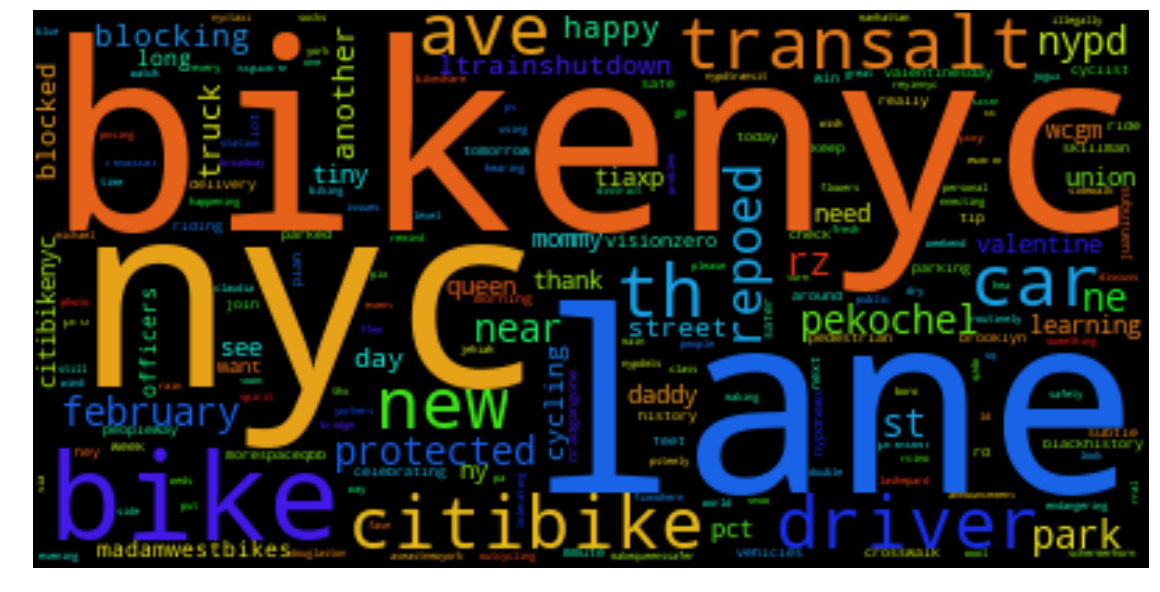

Bigrams:


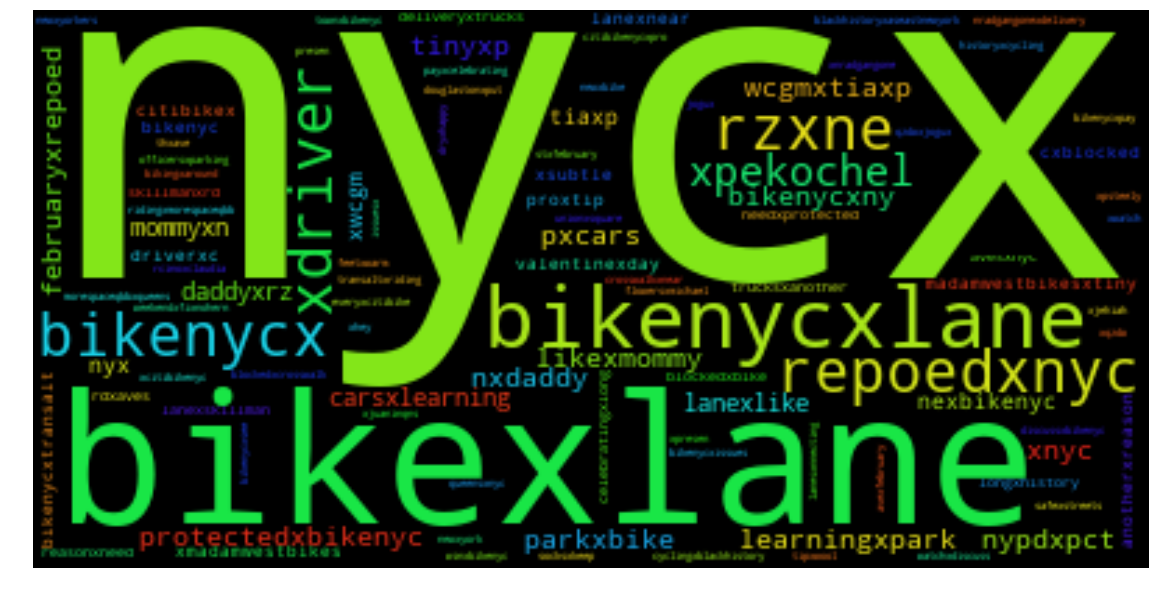

In [30]:
# Single Cloud
wordcloud = WordCloud().generate(clean_tweets)
print('Single Cloud:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

# Bigram Cloud
wordcloud_bigrams = WordCloud().generate(words_bigram)
print('Bigrams:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis("off")
plt.show();

<div class="span25 alert alert-info">
Now the training data is ready for using Bag of Words Analysis.
<br></br>
<br></br>
Initialize the CountVectorizer object, which is scikit-learn's bag of words tool. CountVectorizer converts a collection of text documents to a matrix of token counts.
</div>


## Creating Features from a Bag of Words (Using scikit-learn)¶


In [31]:
vectorizer = CountVectorizer(analyzer="word", preprocessor=None, tokenizer=None, stop_words=None, max_features=5000)

In [32]:
data_features = vectorizer.fit_transform(list(data_tweet['tweet_cleaned'].values))

# Numpy arrays are easy to work with, so convert the result to an array
data_features =data_features.toarray()

In [33]:
tweet_vocab = vectorizer.get_feature_names()
print(tweet_vocab)

['aa', 'ab', 'able', 'abou', 'absence', 'absolutely', 'abstention', 'absurdity', 'according', 'accordingly', 'accurate', 'ace', 'acfkrr', 'across', 'acti', 'action', 'actions', 'activated', 'activist', 'actually', 'ad', 'adamdjacobson', 'adams', 'add', 'additional', 'addressing', 'adjust', 'adventures', 'adverse', 'advice', 'advocate', 'advocates', 'aezfdesy', 'afraid', 'age', 'agencies', 'agency', 'aggregated', 'aggressively', 'aghy', 'agj', 'aglrkwhhjd', 'ago', 'agre', 'ahead', 'ahh', 'ainslie', 'ajrsrwmnsa', 'ak', 'alert', 'alickasamuel', 'allegedly', 'allows', 'almgy', 'almost', 'alnizdyuce', 'along', 'already', 'also', 'alt', 'alter', 'always', 'amanda', 'america', 'amsterdam', 'anne', 'announcement', 'announcements', 'another', 'anyone', 'anything', 'ao', 'ap', 'app', 'appreciated', 'aq', 'area', 'areas', 'around', 'arresting', 'article', 'artists', 'artnouveau', 'artseast', 'artseastnewyork', 'ask', 'asked', 'asphalt', 'assemblymember', 'astoria', 'atjov', 'atoyz', 'attack', 'au

In [34]:
def clean_tweets(tweets, remove_stopwords=False, stem=False):
    """
    to clean tweet strings
    tweet: a list of tweet strings
    remove_stop_words: whether to remove stop words
    output: a list of clean tweets
    """
    # 1. Remove HTML
    tweets_text = list(map(lambda x: BeautifulSoup(x, 'html.parser').get_text(), tweets))
    #
    # 2. Remove non-letters
    tweets_text = list(map(lambda x: re.sub("[^a-zA-Z]"," ", x), tweets_text))
    #
    # 3. Convert words to lower case and split them
    words = list(map(lambda x: x.lower().split(), tweets_text))
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        set_of_stopwords = set(stopwords.words("english"))
        meaningful_words = list(map(lambda x: [w for w in x if not w in set_of_stopwords], words))
    
    # 5. Optionally stem the words
    if stem:
        porter_stemmer = PorterStemmer()
        wordnet_lemmatizer = WordNetLemmatizer()
        stemmed_words = list(map(lambda x: [porter_stemmer.stem(w) for w in x], meaningful_words))
        stemmed_words = list(map(lambda x:[wordnet_lemmatizer.lemmatize(w) for w in x], stemmed_words))
    
        # 6. Join the words to a single string
        clean_tweet = map(lambda x: ' '.join(x), stemmed_words)
    else:
        clean_tweet = list(map(lambda x: ' '.join(x), meaningful_words))
    
    return clean_tweet

In [35]:
# Read the test data
data = pd.read_excel('citibike_data.xls', header=0, delimiter="\t", quoting=3)

#data['cleaned_trip'] = data['tweet'].apply(clean_tweets()) 
print('The dimension of data is {}.'.format(data.shape))

# Get a bag of words for the test set, and convert to a numpy array
#clean_test_tweet = clean_tweets(list(data['tweet'].values), remove_stopwords=True)
#test_data_features = vectorizer.transform(clean_test_tweet)
#test_data_features = test_data_features.toarray()

#data['clean_tweet'] = data['tweet'].apply(lambda txt: clean_tweets(txt, remove_stopwords=True))
#data_tweet['tweet_cleaned'] = data_tweet['tweet_meaningful_words'].apply(lambda x: ' '.join(x)) # comment if using stemming

data = data.drop(['tweet_date', 'created', 'source', 'tweet', 'id'], axis=1)

X = data.drop('SA', axis=1)
y = data.SA.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

X_train.reset_index(inplace=True)
#y_train = y_train.reset_index()

X_test.reset_index(inplace=True)
#y_test = y_test.reset_index()

print("Training set::{}{}".format(X_train.shape,y_train.shape))
print("Testing set::{}{}".format(X_test.shape, y_test.shape))

print(X.info())

The dimension of data is (5084, 15).
Training set::(3558, 10)(3558, 1)
Testing set::(1526, 10)(1526, 1)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5084 entries, 0 to 5083
Data columns (total 9 columns):
fav_count         5084 non-null int64
retweet           5084 non-null int64
len               5084 non-null int64
uppercase_no      5084 non-null int64
hashtag_no        5084 non-null int64
exclamation_no    5084 non-null int64
question_no       5084 non-null int64
mention_no        5084 non-null int64
score             5084 non-null float64
dtypes: float64(1), int64(8)
memory usage: 397.2 KB
None


## Random Forest
Let's try a random forest with the features we just created.

In [36]:
# Initialize a Random Forest classifier with 100 trees
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=42) 

# Fit the forest to the training set, using the bag of words as features and the sentiment labels as labels
# This may take a few minutes to run
rf_clf.fit(X_train, y_train)


/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [37]:
# Use the random forest to make sentiment label predictions
result = rf_clf.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
    mean_absolute_error(y_train, rf_clf.predict(X_train)),
    mean_absolute_error(y_test, result)))
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, rf_clf.predict(X_train)),
    mean_squared_error(y_test, result)))
print('R^2 train: %.3f, test: %.3f' % (
    (r2_score(y_train, rf_clf.predict(X_train)),
    r2_score(y_test, result))))


# Use cross validation to evaluate the performance of Random Forest
rf_clf_error = 1 - cross_val_score(rf_clf, X_train, y_train, 
                                   cv=10, scoring='accuracy', n_jobs=-1).mean()
print('Random Forest training error: {:.4}'.format(rf_clf_error))

# Copy the results to a pandas dataframe with an "id" column an a "sentiment" column
#output = pd.DataFrame(data={"id":X_test["id"], "SA":result})

# Use pandas to write the comma-separated output file
#output.to_csv("sentiment_result.csv", index=False, quoting=3)   
#print("Wrote Twitter sentiment analysis results to sentiment_result")

MAE train: 0.000, test: 0.000
MSE train: 0.000, test: 0.000
R^2 train: 1.000, test: 1.000


/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/sklearn/mod

Random Forest training error: 0.0


In [38]:
print("confusion matrix: ",confusion_matrix(y_test, result))
print("classification report: ", classification_report(y_test, result))


confusion matrix:  [[208   0   0]
 [  0 614   0]
 [  0   0 704]]
classification report:               precision    recall  f1-score   support

         -1       1.00      1.00      1.00       208
          0       1.00      1.00      1.00       614
          1       1.00      1.00      1.00       704

avg / total       1.00      1.00      1.00      1526



In [39]:
rfe = RFE(rf_clf, 5)
fit = rfe.fit(X_test, y_test)

print("Num Features:", fit.n_features_)
print("Selected Features: ", fit.support_) 
print("Feature Ranking:", fit.ranking_)
print(sorted(zip(map(lambda x: round(x, 4), fit.ranking_), X_test.columns)))


/Users/jitendra_agarwal/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Num Features: 5
Selected Features:  [False False  True  True  True  True False False False  True]
Feature Ranking: [6 3 1 1 1 1 4 5 2 1]
[(1, 'hashtag_no'), (1, 'len'), (1, 'retweet'), (1, 'score'), (1, 'uppercase_no'), (2, 'mention_no'), (3, 'fav_count'), (4, 'exclamation_no'), (5, 'question_no'), (6, 'index')]


In [40]:
feature_list = list(X_train.columns)

# Get numerical feature importances
importances = list(rf_clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: score                Importance: 0.85
Variable: retweet              Importance: 0.04
Variable: len                  Importance: 0.03
Variable: uppercase_no         Importance: 0.03
Variable: mention_no           Importance: 0.02
Variable: fav_count            Importance: 0.01
Variable: hashtag_no           Importance: 0.01
Variable: exclamation_no       Importance: 0.01
Variable: index                Importance: 0.0
Variable: question_no          Importance: 0.0
